# Author: Sevendi Eldrige Rifki Poluan

In [49]:
# working environment
!nvidia-smi

Wed May 17 07:57:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   45C    P8    38W / 390W |  23440MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version

In [ ]:
!pip install tensorflow-federated

# Import the necessary libraries

In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import itertools 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prepare the datasets

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
def display_mnist_images(images, labels, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 3))
    axes = axes.ravel()

    for i in np.arange(0, rows * cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(labels[i])

    plt.subplots_adjust(hspace=0.5)
    plt.show()

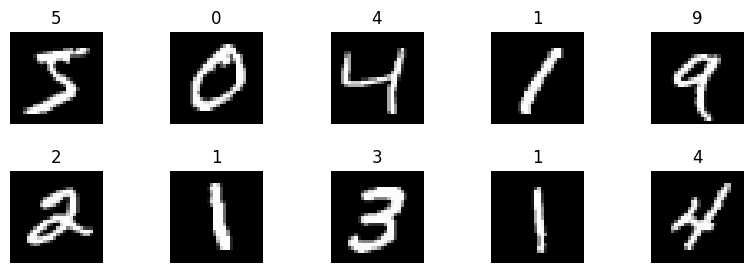

In [6]:
display_mnist_images(train_images[:10], train_labels[:10], rows=2, cols=5)

# Preprocess for federated learning

In this demonstration of federated learning, we will divide the datasets to simulate training on different clients. This allows us to showcase how the training process is performed in a distributed manner across multiple data sources.

<Axes: xlabel='0'>

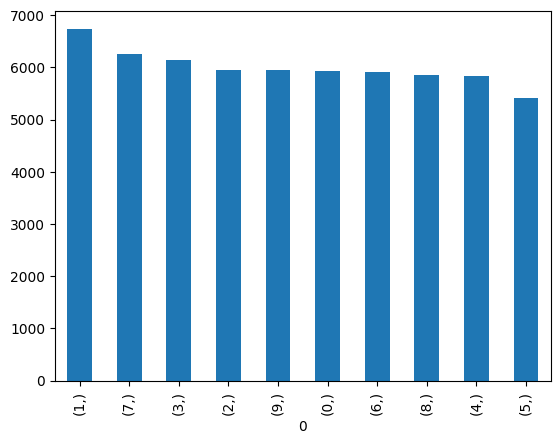

In [15]:
pd.DataFrame(train_labels).value_counts().plot(kind="bar")

The number of sample sets is relatively balanced across each class.

In [48]:
# In this scenario, we will divide the data into multiple clients.
classes = np.unique(train_labels)
clients = 7
datasets = {}
for _class in classes[:]:
    indexes = np.squeeze(np.array(np.where(train_labels == _class)))
    splits = len(indexes) // 7
    start = 0
    for client in range(clients):
        if client not in datasets:
            datasets[client] = {"image": [], "label": []}
        
        if client == clients - 1:
            imgs = train_images[indexes][start:]  
            lbls = train_labels[indexes][start:]
        else: 
            imgs = train_images[indexes][start:start + splits]
            lbls = train_labels[indexes][start:start + splits]
        
        datasets[client]["image"].extend(imgs)
        datasets[client]["label"].extend(lbls)
        
        start += splits
         

In [5]:
def process_data(data):
    image = np.array(data["image"]) / 255
    ds_slices = tf.data.Dataset.from_tensor_slices((image, data["label"]))
    return ds_slices

In [6]:
BATCH_SIZE = 32


client_datasets = [
    process_data(datasets[x]).shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache() for x in datasets.keys()
]
testing_set = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2023-05-17 06:37:39.141140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22244 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


# Build the model

In [7]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(28, 28))
    x = tf.keras.layers.Conv1D(256, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(256, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(512, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    outputs = tf.keras.layers.Dense(len(classes), activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs) 
    
    return model 

In [13]:
global_model = create_model() # global modal
client_models = [create_model() for x in range(clients)] # client model

In [14]:
client_models[0].summary() # client 0

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 conv1d_29 (Conv1D)          (None, 26, 512)           43520     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 13, 512)          0         
 g1D)                                                            
                                                                 
 global_average_pooling1d_9   (None, 512)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               2626

# Train the model

In [15]:
def evaluate(model, testing_set):
    y_preds, y_tests = [], []
    for x in testing_set:
        x_test, y_test = x
        y_pred = tf.argmax(model(x_test), axis=1)
        y_preds.extend(y_pred.numpy())
        y_tests.extend(y_test.numpy()) 
    return accuracy_score(y_preds, y_tests)

In [16]:
# define hyperparameters
learning_rate = 0.001
momentum = 0.9

# define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# perform federated averaging with momentum
num_rounds = 100 
best_accuracy = {
    "global": 0
}
 
for round in range(num_rounds):
    
    print(f"\n-------------------------- Start Round {round}")
    
    aggregated_gradients = []  # List to store the aggregated gradients
    
    for client in range(clients):
        
        # make a copy of the global model for the client
        client_models[client].set_weights(global_model.get_weights())
        
        # perform local training on the client's dataset
        losses = []
        for batch in client_datasets[client]:
            
            features, labels = batch
            
            with tf.GradientTape() as tape:
                logits = client_models[client](features, training=True)
                loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
                
                losses.append(loss)
            
            gradients = tape.gradient(loss, client_models[client].trainable_variables)
            
            # apply momentum to the gradients
            if len(aggregated_gradients) > 0:
                gradients = [momentum * aggregated_gradients[i] + gradients[i] for i in range(len(gradients))]
            
            aggregated_gradients = gradients
        
        # aggregate the gradients from the client
        client_gradients = [gradient / len(client_datasets[client]) for gradient in aggregated_gradients]
        
        # apply the client gradients to the global model
        optimizer.apply_gradients(zip(client_gradients, global_model.trainable_variables))
        
        client_val = evaluate(client_models[client], testing_set)
        
        print(f"Client {client} val accuracy: {client_val}, losses: {np.mean(losses)}") 
    
    # evaluate the global model
    global_accuracy = evaluate(global_model, testing_set)
      
    # save the best model
    if best_accuracy["global"] < global_accuracy:
        print("\nSave global model")
        global_model.save_weights("global.model.weights.h5")
        
        best_accuracy["global"] = global_accuracy
       
    print(f"Round {round}: Global val accuracy = {global_accuracy}")
    


-------------------------- Start Round 0
Client 0 val accuracy: 0.0957, losses: 2.3029911518096924
Client 1 val accuracy: 0.1045, losses: 2.3019180297851562
Client 2 val accuracy: 0.1024, losses: 2.3007493019104004
Client 3 val accuracy: 0.0987, losses: 2.2992868423461914
Client 4 val accuracy: 0.0986, losses: 2.2978010177612305
Client 5 val accuracy: 0.098, losses: 2.295999050140381
Client 6 val accuracy: 0.098, losses: 2.293635845184326

Save global model
Round 0: Global val accuracy = 0.098

-------------------------- Start Round 1
Client 0 val accuracy: 0.098, losses: 2.2909040451049805
Client 1 val accuracy: 0.098, losses: 2.2879838943481445
Client 2 val accuracy: 0.098, losses: 2.284771203994751
Client 3 val accuracy: 0.0992, losses: 2.2810118198394775
Client 4 val accuracy: 0.1058, losses: 2.27874755859375
Client 5 val accuracy: 0.114, losses: 2.2762582302093506
Client 6 val accuracy: 0.125, losses: 2.2725398540496826

Save global model
Round 1: Global val accuracy = 0.1438

--

Client 3 val accuracy: 0.4958, losses: 1.9462612867355347
Client 4 val accuracy: 0.5069, losses: 1.9480397701263428
Client 5 val accuracy: 0.5218, losses: 1.938149333000183
Client 6 val accuracy: 0.5395, losses: 1.9233126640319824

Save global model
Round 16: Global val accuracy = 0.5527

-------------------------- Start Round 17
Client 0 val accuracy: 0.5527, losses: 1.9288289546966553
Client 1 val accuracy: 0.5565, losses: 1.9352822303771973
Client 2 val accuracy: 0.5525, losses: 1.9228237867355347
Client 3 val accuracy: 0.5405, losses: 1.9251083135604858
Client 4 val accuracy: 0.5373, losses: 1.928431749343872
Client 5 val accuracy: 0.5375, losses: 1.918143630027771
Client 6 val accuracy: 0.5457, losses: 1.902696132659912

Save global model
Round 17: Global val accuracy = 0.5547

-------------------------- Start Round 18
Client 0 val accuracy: 0.5547, losses: 1.9086118936538696
Client 1 val accuracy: 0.5621, losses: 1.918056845664978
Client 2 val accuracy: 0.5725, losses: 1.90872299


Save global model
Round 32: Global val accuracy = 0.7448

-------------------------- Start Round 33
Client 0 val accuracy: 0.7448, losses: 1.7455353736877441
Client 1 val accuracy: 0.7394, losses: 1.757625699043274
Client 2 val accuracy: 0.7403, losses: 1.7442281246185303
Client 3 val accuracy: 0.7456, losses: 1.7460434436798096
Client 4 val accuracy: 0.752, losses: 1.7552839517593384
Client 5 val accuracy: 0.7512, losses: 1.7400020360946655
Client 6 val accuracy: 0.7468, losses: 1.724370002746582
Round 33: Global val accuracy = 0.7412

-------------------------- Start Round 34
Client 0 val accuracy: 0.7412, losses: 1.7373467683792114
Client 1 val accuracy: 0.7421, losses: 1.748504400253296
Client 2 val accuracy: 0.7475, losses: 1.7375653982162476
Client 3 val accuracy: 0.7583, losses: 1.734971284866333
Client 4 val accuracy: 0.7678, losses: 1.7479275465011597
Client 5 val accuracy: 0.7691, losses: 1.7361267805099487
Client 6 val accuracy: 0.7576, losses: 1.7177835702896118

Save glob

Client 4 val accuracy: 0.7892, losses: 1.6746658086776733
Client 5 val accuracy: 0.7873, losses: 1.672725796699524
Client 6 val accuracy: 0.7857, losses: 1.6517506837844849
Round 49: Global val accuracy = 0.7888

-------------------------- Start Round 50
Client 0 val accuracy: 0.7888, losses: 1.6637710332870483
Client 1 val accuracy: 0.7925, losses: 1.678009271621704
Client 2 val accuracy: 0.7982, losses: 1.664690375328064
Client 3 val accuracy: 0.8026, losses: 1.6727180480957031
Client 4 val accuracy: 0.8047, losses: 1.675015926361084
Client 5 val accuracy: 0.8022, losses: 1.6670347452163696
Client 6 val accuracy: 0.7898, losses: 1.649911880493164
Round 50: Global val accuracy = 0.7856

-------------------------- Start Round 51
Client 0 val accuracy: 0.7856, losses: 1.6610115766525269
Client 1 val accuracy: 0.7838, losses: 1.6738648414611816
Client 2 val accuracy: 0.7893, losses: 1.6630090475082397
Client 3 val accuracy: 0.7966, losses: 1.666503667831421
Client 4 val accuracy: 0.8062,

Client 2 val accuracy: 0.7939, losses: 1.6295663118362427
Client 3 val accuracy: 0.7948, losses: 1.637032151222229
Client 4 val accuracy: 0.7995, losses: 1.636434555053711
Client 5 val accuracy: 0.803, losses: 1.6354173421859741
Client 6 val accuracy: 0.8073, losses: 1.6137027740478516
Round 66: Global val accuracy = 0.8149

-------------------------- Start Round 67
Client 0 val accuracy: 0.8149, losses: 1.628631830215454
Client 1 val accuracy: 0.8177, losses: 1.6345394849777222
Client 2 val accuracy: 0.8152, losses: 1.6307295560836792
Client 3 val accuracy: 0.8152, losses: 1.6362947225570679
Client 4 val accuracy: 0.8157, losses: 1.635683298110962
Client 5 val accuracy: 0.8101, losses: 1.6387953758239746
Client 6 val accuracy: 0.8072, losses: 1.614846110343933
Round 67: Global val accuracy = 0.8099

-------------------------- Start Round 68
Client 0 val accuracy: 0.8099, losses: 1.6302237510681152
Client 1 val accuracy: 0.8122, losses: 1.6350806951522827
Client 2 val accuracy: 0.8084,

Client 1 val accuracy: 0.7968, losses: 1.6145846843719482
Client 2 val accuracy: 0.793, losses: 1.607901930809021
Client 3 val accuracy: 0.7915, losses: 1.6159768104553223
Client 4 val accuracy: 0.7967, losses: 1.6140161752700806
Client 5 val accuracy: 0.8021, losses: 1.6125956773757935
Client 6 val accuracy: 0.8051, losses: 1.593299388885498
Round 83: Global val accuracy = 0.8125

-------------------------- Start Round 84
Client 0 val accuracy: 0.8125, losses: 1.607138991355896
Client 1 val accuracy: 0.8134, losses: 1.6150315999984741
Client 2 val accuracy: 0.8043, losses: 1.608777642250061
Client 3 val accuracy: 0.7976, losses: 1.6128368377685547
Client 4 val accuracy: 0.7902, losses: 1.6107683181762695
Client 5 val accuracy: 0.7865, losses: 1.6075010299682617
Client 6 val accuracy: 0.7872, losses: 1.5934274196624756
Round 84: Global val accuracy = 0.7905

-------------------------- Start Round 85
Client 0 val accuracy: 0.7905, losses: 1.6048941612243652
Client 1 val accuracy: 0.8012

# Test and evaluate the global model

In [24]:
!ls 'Saved model'

global.model.weights.h5


In [25]:
global_model_test = create_model()

In [26]:
global_model_test.load_weights("Saved model/global.model.weights.h5")

In [37]:
def model_evaluation(model, testing_set):
    y_preds, y_tests = [], []
    for x in testing_set:
        x_test, y_test = x
        y_pred = tf.argmax(model(x_test), axis=1)
        y_preds.extend(y_pred.numpy())
        y_tests.extend(y_test.numpy()) 
    return y_preds, y_tests

In [45]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=20)
    plt.yticks(fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=12)

In [38]:
y_true, y_pred = model_evaluation(global_model_test, testing_set)

In [40]:
# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
confusion_mat = confusion_matrix(y_true, y_pred)

# Print the measurements

In [42]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_mat))

Accuracy: 0.8309
Precision: 0.829717748647165
Recall: 0.8529441334978521
F1-score: 0.8299236139830402

Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  944     1    5    0   49    1   22    3   31   27
1    0  1061    0    0    1    1    2    1    0    2
2    3    11  725   10   19   19    5   91   11   50
3    1     7  231  986    3  121    6   75   28   73
4    0     0    1    0  574    0    0    4    0    0
5    1     1   35    8    4  706   23   14    7    4
6    0     9    1    0   21    0  822    1    1    2
7    0    27    3    0   22    2    1  779    0    2
8   31    16   18    4   23   40   76    0  893   30
9    0     2   13    2  266    2    1   60    3  819


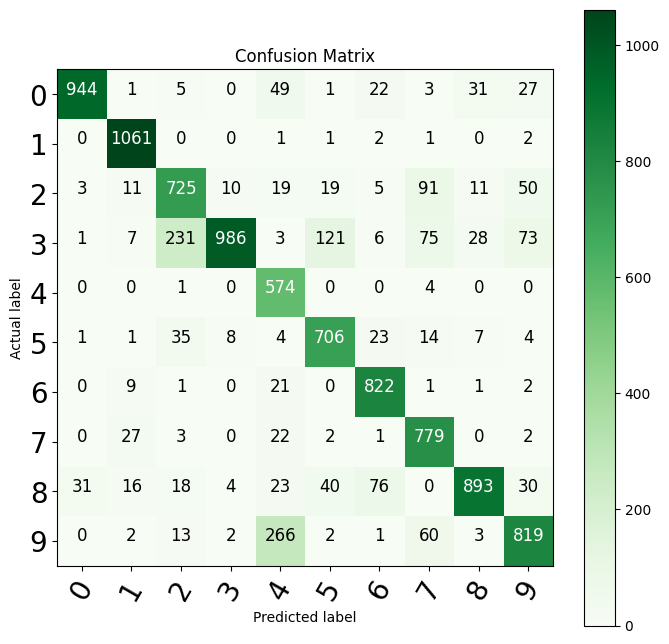

In [46]:
conf_matrix(y_test=y_true, y_pred=y_pred, class_names=range(10))

This project serves as a demonstration of the federated learning concept. While there are opportunities for further improvement in the model, it showcases the remarkable capability of training a model on diverse devices and aggregating them on a distributed server. The ability to leverage data from multiple sources in a collaborative manner is a captivating aspect of federated learning.